# Barghi et al. (2019) Data Processing and Analysis

## Setup

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [4]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

# Data and Annotation Loading

### Load in SyncFile

In [6]:
CACHED_SYNC = '../data/barghi_et_al_2019/barghi_et_al_2019.hdf5'
SYNC_FILE = '../data/barghi_et_al_2019/Dsim_F0-F60_Q20_polymorphic_CMH_FET_blockID.sync.gz'

if not os.path.exists(CACHED_SYNC):
    sf = vf.SyncFile(SYNC_FILE)
    sf.dump_hdf5(CACHED_SYNC)
else:
    sf = vf.SyncFile.load_hdf5(CACHED_SYNC)

total time to load HDF5 file: 0.1248116135597229 mins.


In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('../data/dsimulans/dsim-M252-seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
keep_seqids = ['2L', '2R', '3L', '3R', 'X']
keep_autos = ['2L', '2R', '3L', '3R']

### Study Design

Next, we parse the sample names  the `README.docx` file (https://datadryad.org/resource/doi:10.5061/dryad.rr137kn/1).

From the readme, the sample name formats are,

```
for the base populations:      species_population_selectionRegime_replicate: e.g. Dsim_Fl_Base_4 
for the evolved populations:   species_population_selectionRegime_generation_replicate: e.g. Dsim_Fl_Hot_F13_1
```

which we parse using regular expressions:

In [9]:
CACHED_DESIGN = '../data/barghi_et_al_2019/barghi_et_al_2019_design.feather'

if not os.path.exists(CACHED_DESIGN):
    RAW_DESIGN_FILE = '../data/barghi_et_al_2019/barghi_et_al_2019_design.txt'
    sample_names = pd.read_csv(RAW_DESIGN_FILE, header=None, names=('col', ))['col'].tolist()
    sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
    sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
    design = pd.DataFrame.from_dict(sample_info)
    
    # Barghi et al use base population to refer to generation zero — we set that explicitly here:
    design.loc[design.gen.isnull(), 'gen'] = 0
    design['gen'] = design['gen'].astype('int')
    
    design.to_feather(CACHED_DESIGN)
else:
    design = pd.read_feather(CACHED_DESIGN)

Our `TemporalFreqs()` and `TiledTemporalFreqs()` objects take a list of tuples `(timepoint, replicate)`, which we create via the design DataFrame:

In [10]:
samples = [(int(t), int(r)) for t, r in zip(design['rep'].values, design['gen'].values)]

### Import Annotation

We use the M252 reference genome annotation described by Palmieriet al. (2015). 
These sequence lengths are used for the creation of the tiles.

In [11]:
gtf_file = '../data/dsimulans/dsim-M252-popgen-ann-r1.1.sorted.gtf'
keep_seqids = set('2L 2R 3L 3R 4 X'.split())
dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))

In [12]:
dsim

GenomicIntervals — 6 unique seqids, 169132 features
   GenomicInterval attributes phase   score seqid          source strand  type
0  2L:[3589, 4976)       None     .  1000.0    2L       Cufflinks      -  exon
1  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
2  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
3  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
4  2L:[4941, 4976)       None     2     NaN    2L  protein2genome      -  exon
[ 169127 more GenomicIntervals ]

In [13]:
dsim.infer_seqlens()

## Covariance Analysis

### Creating Tiles

In [14]:
tile_width = 1e5
tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=tile_width)
# add in exonic basepairs:
#tiles = tiles.overlap_coverage(dsim, colname='exonic_bp')

### Creating TiledTemporalFreqs object

In [15]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=1000, gintervals=sf_gi, samples=samples)

In [ ]:
del sf

### Genome-wide Covariances

In [80]:
gw_covs = d.calc_covs()

In [82]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[ 1.99536671e-02,  1.98915807e-03,  5.13227972e-04,
         5.64228407e-04, -1.46052055e-05, -3.51253500e-04],
       [ 1.98915807e-03,             nan,             nan,
         5.76136185e-04,  2.68058809e-04, -2.61952102e-04],
       [ 5.13227972e-04,             nan,             nan,
         2.45187408e-03,  9.89771042e-04,  2.77429856e-04],
       [ 5.64228407e-04,  5.76136185e-04,  2.45187408e-03,
         1.67597748e-02,  1.35323996e-03,  1.30402073e-04],
       [-1.46052055e-05,  2.68058809e-04,  9.89771042e-04,
         1.35323996e-03,  1.27813426e-02,  1.58092804e-03],
       [-3.51253500e-04, -2.61952102e-04,  2.77429856e-04,
         1.30402073e-04,  1.58092804e-03,  1.07419273e-02]])

### Genome-wide G

Averaging across replicates:

In [73]:
g_averep = d.calc_G(average_replicates=True)
with open('../data/barghi_et_al_2019/g_averep.npy', 'wb') as f:
    np.save(f, g_averep)

Not averaging across replicates:

In [75]:
g = d.calc_G(average_replicates=False)
with open('../data/barghi_et_al_2019/g.npy', 'wb') as f:
    np.save(f, g)

### Calculating Temporal-Replicate Covariances per Tile
Calculate the temporal-replicate covariances matrices for all tiles. Each covariance matrix has R x T = 60 rows and columns. 

In [16]:
tile_covs = d.calc_covs_by_tile(progress_bar=True)

We reshape these 60 x 60 matrices, extracting the temporal replicates. This gives the ntiles x T x T x R array of temporal covaraince matrices, for each of the R replicates. This numpy array is used to create figures. 

In [17]:
tile_temp_covs = stack_temporal_covs_by_group(tile_covs, d.R, d.T)
with open('../data/barghi_et_al_2019/tile_temporal_covs.npy', 'wb') as f:
    np.save(f, tile_temp_covs)

### Bias Correction Diagnostics Plots

/home/vinceb/projects/cvtk/cvtk/cvtk.py:197: RuntimeWarning: Mean of empty slice.
  het = het.mean()
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


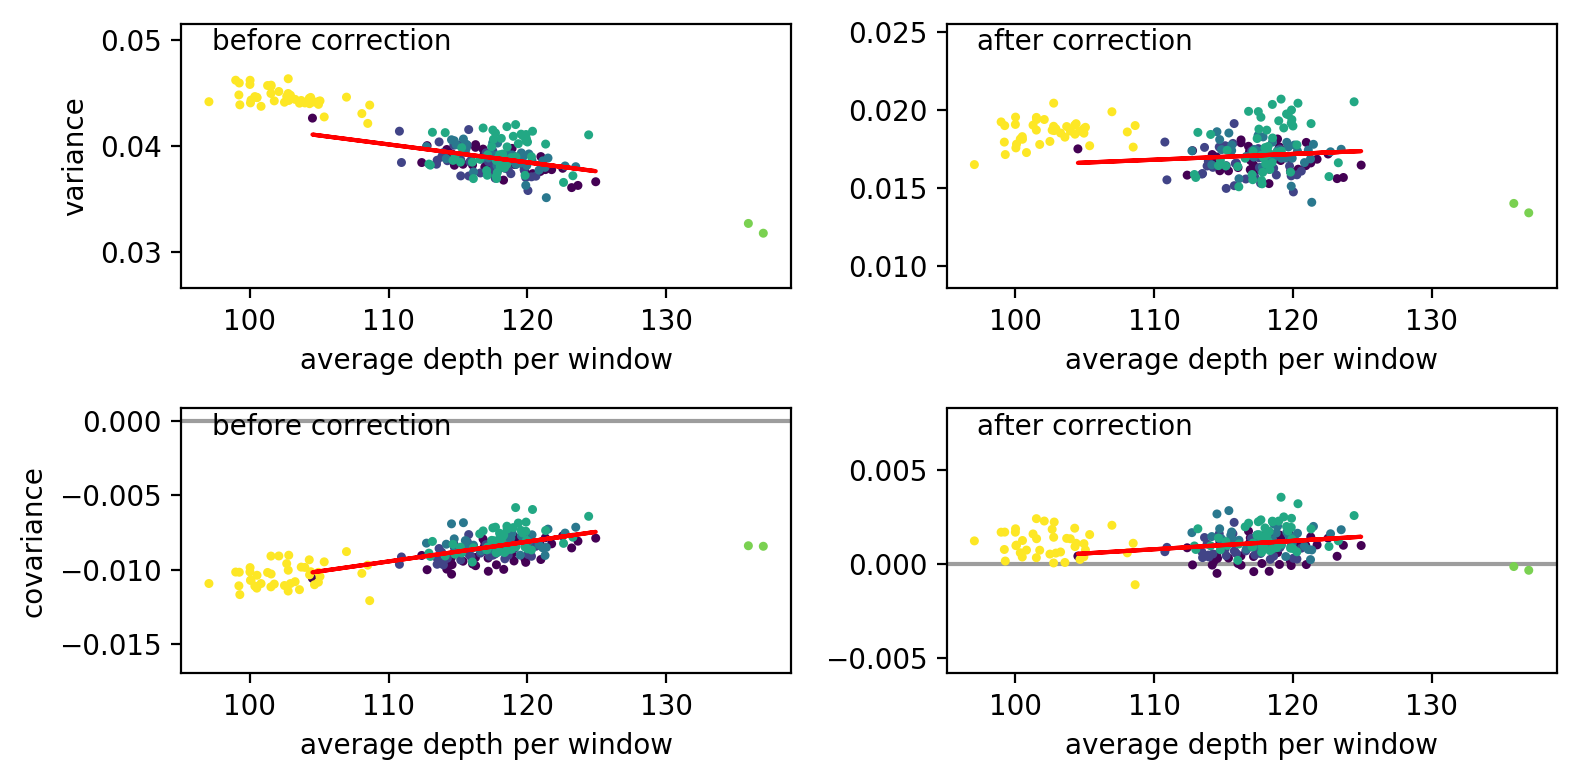

In [85]:
diagnostics = d.correction_diagnostics(exclude_seqids=['X', '4'])
_ = correction_diagnostic_plot(diagnostics)

## Bootstrapping Covariances and G — Megabase tiles

We need a compromise over long enough blocks that it's reasonable to expect covariance between sites has broken down, and enough blocks that we don't have too "blocky" of a distribution of covariance bootstraps.

We use 1Mb tiles, but other runs may include smaller and larger window sizes.

In [25]:
megabase_tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=1e6)
d.set_tiles(megabase_tiles)
print("number of blocks: ", len(d.tile_indices))

number of blocks:  108


### Bootstrapping Temporal Covs

Bootstrap the temporal covariances, averaging over all replicates.

In [71]:
gw_temp_covs_cis = d.bootstrap_cov(B=5000, average_replicates=True, progress_bar=True)

with open('../data/barghi_et_al_2019/gw_temp_covs_cis.npy', 'wb') as f:
    np.save(f, gw_temp_covs_cis)

Bootstrap the entire temporal-replicate covariance matrix.

In [72]:
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

with open('../data/barghi_et_al_2019/gw_covs_cis.npy', 'wb') as f:
    np.save(f, gw_covs_cis)

### Bootstrapping G

First, we get the estimated G and save it:

In [68]:
g_estimate = d.calc_G(average_replicates=False)

with open('../data/barghi_et_al_2019/g_estimate.npy', 'wb') as f:
    np.save(f, g_estimate)

Bootstrap the measure G, not averaging over all replicates.

In [69]:
# G *not* averaging replicates
g_cis = d.bootstrap_G(B=5000, progress_bar=True)

with open('../data/barghi_et_al_2019/g_cis.npy', 'wb') as f:
    np.save(f, g_cis)

Bootstrap the measure G, averaging over all replicates.

In [70]:
# G averaging replicates
g_cis_averep = d.bootstrap_G(B=5000, average_replicates=True, progress_bar=True)

with open('../data/barghi_et_al_2019/g_cis_averep.npy', 'wb') as f:
    np.save(f, g_cis_averep)

### Bootstrap Whole Temporal-Replicate Covariance Matrix

In [19]:
temprep_covs_bs = d.bootstrap_covs(B=5000, progress_bar=True)

### Replicates

In [56]:
([stack_replicate_covariances(temprep_covs_bs[0], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() / 
  stack_temporal_covariances(temprep_covs_bs[0], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() for t in range(1, d.T)],

[stack_replicate_covariances(temprep_covs_bs[1], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() / 
  stack_temporal_covariances(temprep_covs_bs[1], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() for t in range(1, d.T)],
 
 
[stack_replicate_covariances(temprep_covs_bs[2], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() / 
  stack_temporal_covariances(temprep_covs_bs[2], d.R, d.T, stack=True).mean(axis=2)[:t, :t].sum() for t in range(1, d.T)])

([0.08266426815243515,
  0.05798993839031108,
  0.032198623878701406,
  0.018240628033131298,
  0.008317769332439256],
 [0.09542073283804459,
  0.08246905595350165,
  0.0689501684808025,
  0.06608474885523936,
  0.06783247134708148],
 [0.10755647428537778,
  0.1051113516024064,
  0.10193485324630681,
  0.10776840947022089,
  0.11808442646104463])

### Empirical Null Distributions via Sign Permutation

These are memory intensive to calculate, so it may not be a bad idea to run one, restart the kernel and run pre-requisite lines above and let the code below save the object, and so on.

In [ ]:
CACHED_EMPCOV_TILE = '../data/barghi_et_al_2019/empnull_tile.npy'
FORCE = True

# tile empirical null with tile-level block permutation (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_TILE):
    empcov_tile = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile',
                                        bias_correction=False,
                                        progress_bar=True)
    with open(CACHED_EMPCOV_TILE, 'wb') as f:
        np.save(f, empcov_tile)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = np.load(f)

In [ ]:
CACHED_EMPCOV_TILE_WITH_CORRECTION = '../data/barghi_et_al_2019/empnull_tile_with_bias_correction.npy'

# tile empirical null with tile-level block permutation (*with* bias correction)
if FOR or not os.path.exists(CACHED_EMPCOV_TILE_WITH_CORRECTION):
    empcov_tile_with_corr = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile', 
                                                  bias_correction=True,
                                                  progress_bar=True)
    with open(CACHED_EMPCOV_TILE_WITH_CORRECTION, 'wb') as f:
        np.save(f, empcov_tile_with_corr)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = np.load(f)  

In [ ]:
CACHED_EMPCOV_TILE_WITH_CORRECTION = '../data/barghi_et_al_2019/empnull_tile_with_bias_correction.npy'

# tile empirical null with seqid-level block permutation (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_TILE_SEQID):
    empcov_tile_seqid = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='seqid',
                                              bias_correction=False,                                              
                                              progress_bar=True)
    with open(CACHED_EMPCOV_TILE_SEQID, 'wb') as f:
        np.save(f, empcov_tile_seqid)
else:   
    with open(CACHED_EMPCOV_TILE_SEQID, 'rb') as f:
        empcov_tile_seqid = np.load(f)
        

In [ ]:
CACHED_EMPCOV_GW = '../data/barghi_et_al_2019/empnull_reshape_gw.npy'

# genome-wide empirical null (no bias correction)
if FORCE or not os.path.exists(CACHED_EMPCOV_GW):
    empcov_gw = d.calc_empirical_null(B=1000, by_tile=False,
                                      bias_correction=False,                                      
                                      progress_bar=True)
    with open(CACHED_EMPCOV_GW, 'wb') as f:
        np.save(f, empcov_gw)
else:
    with open(CACHED_EMPCOV_GW, 'rb') as f:
        empcov_gw = np.load(f)

### SVD 

In [117]:
res = [optimal_N_svd(b, i, progress_bar=True) for i in np.arange(d.R)]

ValueError: attempt to get argmin of an empty sequence

### Alternate G

In [20]:
gw_temp_covs = stack_temporal_covariances(d.calc_covs(standardize=False), d.R, d.T)

In [51]:
from cvtk.cov import total_variance
gw_vars = np.stack([total_variance(d.freqs, t=t, standardize=False) for t in np.arange(d.T+1)])

In [52]:
gw_vars

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00358565, 0.00323979, 0.00381784, 0.00389675, 0.00398064,
        0.00404773, 0.00412002, 0.0042057 , 0.00360681, 0.00481083],
       [0.00574614, 0.00619016, 0.00643623, 0.00724996, 0.00656742,
        0.00575917, 0.00676889, 0.006079  , 0.00590314, 0.00955782],
       [0.00798318, 0.00787952, 0.01013637, 0.01039705, 0.01064503,
        0.00893601, 0.00900319, 0.00911941, 0.00730285, 0.00787342],
       [0.0092355 , 0.00949005, 0.0121434 , 0.01294969, 0.01174627,
        0.01035427, 0.01069503, 0.01316417, 0.01073234, 0.01061904],
       [0.01107629, 0.01179483, 0.01438041, 0.01383625, 0.01486565,
        0.01203857, 0.01212723, 0.01486421, 0.01117223, 0.01290793],
       [0.01161521, 0.01270751, 0.01633829, 0.01575887, 0.01590283,
        0.01339248, 0.01341168, 0.01666055, 0.01248348, 0.01410008]])

In [53]:
gw_vars.mean(axis=1)

array([0.        , 0.00393118, 0.00662579, 0.0089276 , 0.01111298,
       0.01290636, 0.0142371 ])

In [54]:
gw_covs = gw_temp_covs.mean(axis=2)

In [55]:
gw_vars.mean(axis=1)

array([0.        , 0.00393118, 0.00662579, 0.0089276 , 0.01111298,
       0.01290636, 0.0142371 ])

/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: invalid value encountered in true_divide
  G = total_cov / total_var
/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: divide by zero encountered in true_divide
  G = total_cov / total_var


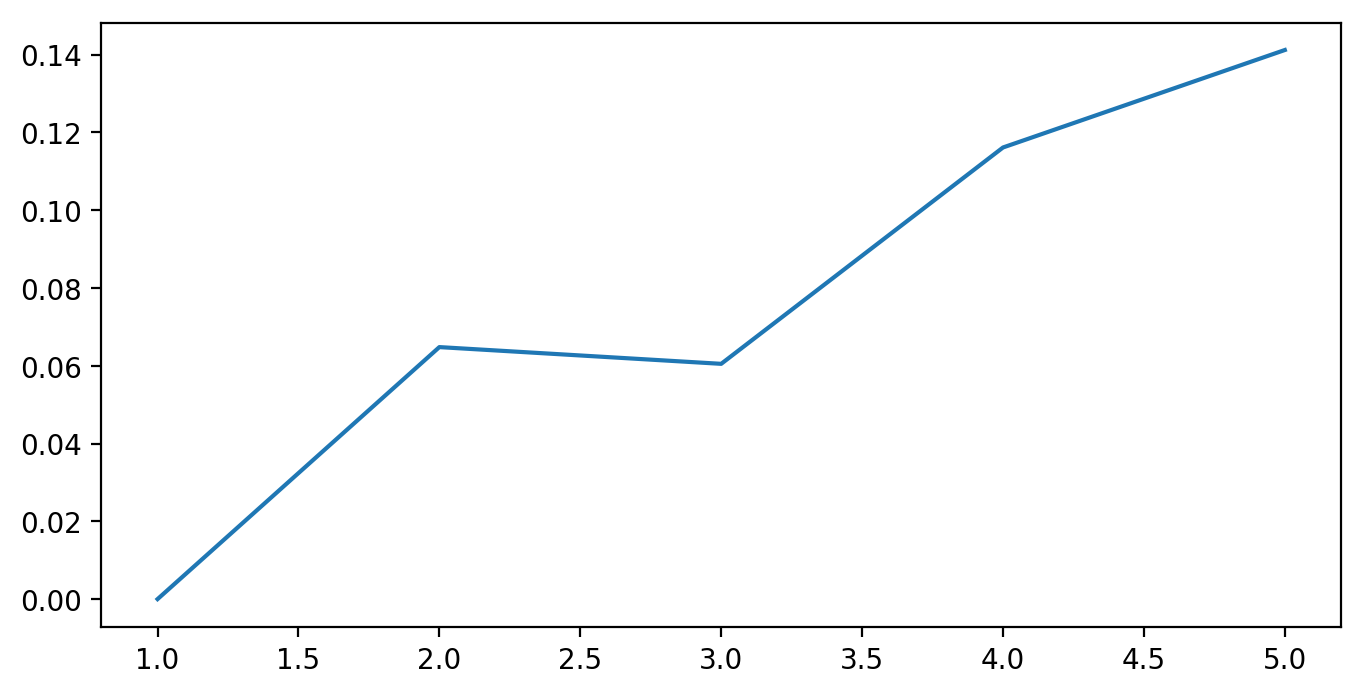

In [56]:
plt.plot(np.arange(1, d.T), [calc_G2(gw_covs, gw_vars.mean(axis=1), end=t)[t] for t in np.arange(1, d.T)])

In [62]:
from cvtk.G import calc_G2
rep_Gs = []
for rep in np.arange(d.R):
    rep_Gs.append([calc_G2(gw_temp_covs[:, :, rep], gw_vars[:, rep][t], end=t) for t in np.arange(d.T+1)])

/home/vinceb/projects/cvtk/cvtk/G.py:25: RuntimeWarning: invalid value encountered in double_scalars
  G = total_cov / total_var


In [63]:
np.stack(rep_Gs).shape

(10, 7)

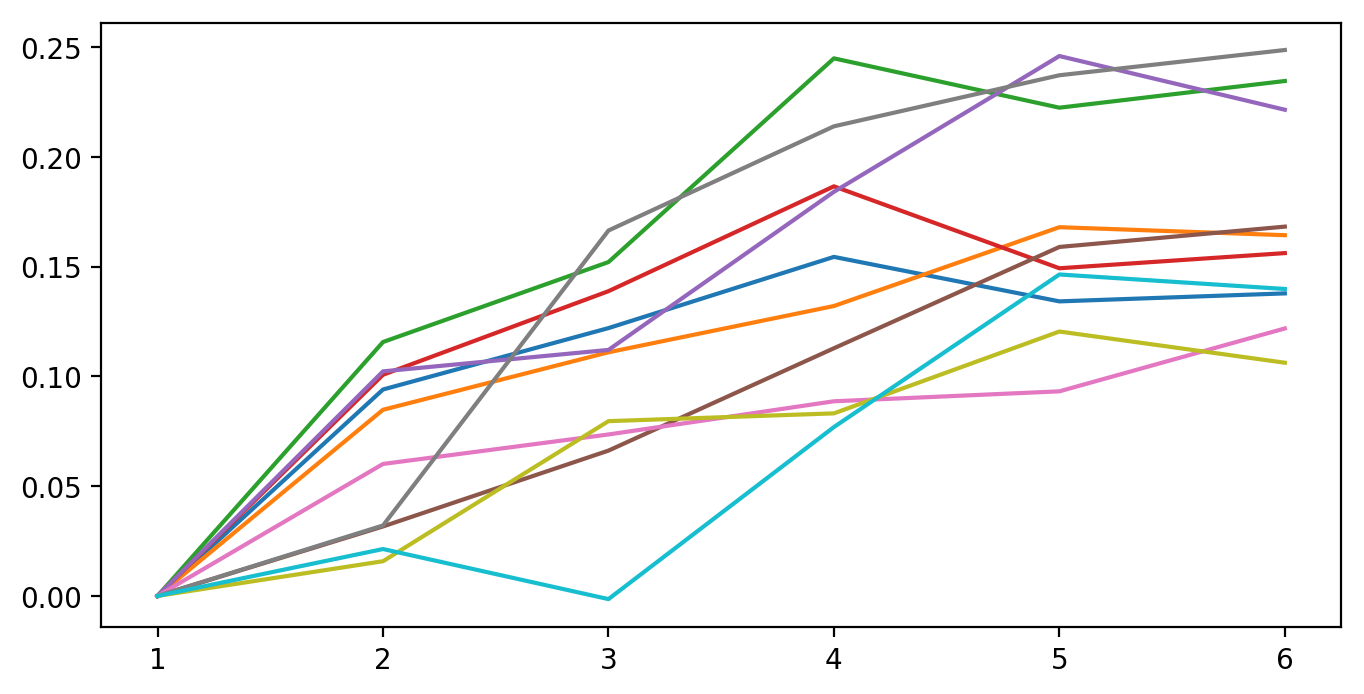

In [66]:
plt.plot(np.stack(rep_Gs).T)

In [24]:
np.stack(d.calc_var_by_tile()).shape

(1106, 10)

In [64]:
gw_covs = gw_temp_covs.mean(axis=2)

In [396]:
gw_covs

array([[ 1.99536665e-02,  1.98915571e-03,  5.13228705e-04,
         5.64226255e-04, -1.46022807e-05, -3.51259497e-04],
       [ 1.98915571e-03,             nan,             nan,
         5.76140898e-04,  2.68059077e-04, -2.61950388e-04],
       [ 5.13228705e-04,             nan,             nan,
         2.45187998e-03,  9.89769514e-04,  2.77426937e-04],
       [ 5.64226255e-04,  5.76140898e-04,  2.45187998e-03,
         1.67597782e-02,  1.35323507e-03,  1.30402633e-04],
       [-1.46022807e-05,  2.68059077e-04,  9.89769514e-04,
         1.35323507e-03,  1.27813475e-02,  1.58093148e-03],
       [-3.51259497e-04, -2.61950388e-04,  2.77426937e-04,
         1.30402633e-04,  1.58093148e-03,  1.07419270e-02]])

In [404]:
#[plt.plot(np.arange(t, 5), gw_covs[t, (t+1):], '-o') for t in np.arange(d.T)]


array([[0.        , 0.        , 0.05778172, 0.09042584, 0.13037347,
        0.14452188, 0.14172667],
       [0.        , 0.        , 0.06206277, 0.0951566 , 0.13475107,
        0.14993367, 0.14525115],
       [0.        , 0.        , 0.06434085, 0.09954967, 0.13917947,
        0.15478225, 0.15152296]])